In [25]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

np.random.seed(0)

# Загрузка данных и первичный анализ

In [26]:
titanic_data = pd.read_csv('data/titanic/train.csv',
                           index_col='PassengerId')
titanic_data = titanic_data.reset_index(drop=True)
print('Количество наблюдений в train:', len(titanic_data))
titanic_data.sample(5)

Количество наблюдений в train: 891


,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
495,0,3,"Yousseff, Mr. Gerious",male,NaN,0,0,2627,14.4583,NaN,C
648,0,3,"Willey, Mr. Edward",male,NaN,0,0,S.O./P.P. 751,7.5500,NaN,S
278,0,3,"Rice, Master. Eric",male,7.0,4,1,382652,29.1250,NaN,Q
31,1,1,"Spencer, Mrs. William Augustus (Marie Eugenie)",female,NaN,1,0,PC 17569,146.5208,B78,C
255,1,3,"Touma, Mrs. Darwis (Hanne Youssef Razi)",female,29.0,0,2,2650,15.2458,NaN,C


In [27]:
# типы данных
titanic_data.dtypes

Survived      int64
Pclass        int64
Name         object
Sex          object
Age         float64
SibSp         int64
Parch         int64
Ticket       object
Fare        float64
Cabin        object
Embarked     object
dtype: object

In [28]:
# пропущенные значения
titanic_data.isnull().sum()

Survived      0
Pclass        0
Name          0
Sex           0
Age         177
SibSp         0
Parch         0
Ticket        0
Fare          0
Cabin       687
Embarked      2
dtype: int64

In [29]:
titanic_data['Ticket'].nunique()

681

# Формирование обучающей выборки
**Удалим** признаки:
 - Name
 - Cabin
 - Ticket

In [30]:
X = titanic_data.drop(['Name', 'Cabin', 'Ticket', 'Survived'], axis=1)
y = titanic_data['Survived']

# Кодирование номинативных переменных
Будем использовать OneHotEncoding подход

In [31]:
X.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,male,22.0,1,0,7.2500,S
1,1,female,38.0,1,0,71.2833,C
2,3,female,26.0,0,0,7.9250,S
3,1,female,35.0,1,0,53.1000,S
4,3,male,35.0,0,0,8.0500,S


In [32]:
X = pd.get_dummies(X)
X.sample(3)

,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
710,1,24.0,0,0,49.5042,1,0,1,0,0
481,2,NaN,0,0,0.0000,0,1,0,0,1
726,2,30.0,3,0,21.0000,1,0,0,0,1


In [33]:
X = X.drop('Sex_female', axis=1)
X = X.fillna({'Age': X.Age.median()})
X.head()

,Pclass,Age,SibSp,Parch,Fare,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,3,22.0,1,0,7.2500,1,0,0,1
1,1,38.0,1,0,71.2833,0,1,0,0
2,3,26.0,0,0,7.9250,0,0,0,1
3,1,35.0,1,0,53.1000,0,0,0,1
4,3,35.0,0,0,8.0500,1,0,0,1


# Модель: решающее дерево
Решающее дерево не находит закономерности в данных. Оно лишь пытается "подойти" под данные. Поэтому необходимо тщательно регулировать параметры обучения (в частности параметр max_depth, который ограничивает высоту дерева).

In [34]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=19)
clf = DecisionTreeClassifier(criterion='entropy', max_depth=7)
clf.fit(X_train, y_train)

print('Качество: ', clf.score(X_test, y_test))

Качество:  0.8430493273542601


In [35]:
depths = range(1, 100)
scores = pd.DataFrame(columns=['depth', 'test score', 'train score'])

for i in depths:
    clf = DecisionTreeClassifier(criterion='entropy', max_depth=i)
    clf.fit(X_train, y_train)
    train_accuracy = clf.score(X_train, y_train)
    test_accuracy = clf.score(X_test, y_test)
    scores.loc[len(scores)] = [i, test_accuracy, train_accuracy]
scores.sample(3)

,depth,test score,train score
95,96.0,0.811659,0.983533
77,78.0,0.802691,0.983533
48,49.0,0.811659,0.983533


In [36]:
# перейдем теперь к другому формату представления данных: train/test score -> score
scores = pd.melt(scores,
                 id_vars=['depth'],
                 value_vars=['test score', 'train score'],
                 var_name='type',
                 value_name='score')
scores.sample(3)

,depth,type,score
168,70.0,train score,0.983533
176,78.0,train score,0.983533
33,34.0,test score,0.807175


<AxesSubplot:xlabel='depth', ylabel='score'>

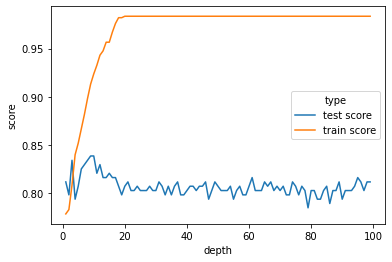

In [37]:
sns.lineplot(x='depth', y='score', hue='type', data=scores)

In [38]:
scores.groupby('type')['score'].max()

type
test score     0.838565
train score    0.983533
Name: score, dtype: float64

In [39]:
scores[scores['score']==scores.groupby('type')['score'].max().loc['test score']]

,depth,type,score
8,9.0,test score,0.838565
9,10.0,test score,0.838565


# Кросс-валидация
Почему не подходит простой вариант обучения?  
Проблема в том, что мы не меняем тестовую выборку. Каждый раз мы делаем проверку на одной и той же тестовую выборке, поэтому, на самом деле, мы пытаемся "подогнать" модель под нее (наш финальная модель - это модель, показавшая наилучшее качества на тестовой выборке)

Обычно данный разбиваются следующим образом:
- тренировочная выборка 
- валидационная выборка (для настройки параметров модели)
- тестовая выборка, на которой и проверяем качество


**k-fold cross-validation**: данные разбиваются на тренировочную и тестовую выборки. Затем тренировочная выборка разбивается на k частей. Процесс обучения повторяется k раз: каждый раз модель обучается на k-1 части тренировочной выборки, а делает проверку на k-ой части. Затем все усредняется и выдается "финальная" оценка модели на валидации.
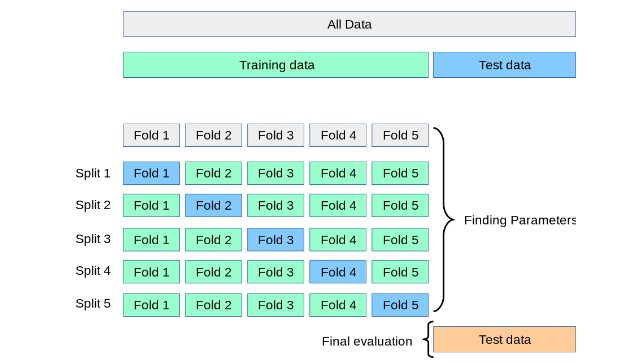

In [40]:
from sklearn.model_selection import cross_val_score

clf = DecisionTreeClassifier(criterion='entropy', max_depth=7)
cross_val_score(clf, X_train, y_train, cv=7)

array([0.85416667, 0.79166667, 0.79166667, 0.76842105, 0.74736842,
       0.75789474, 0.85263158])

In [41]:
depths = range(1, 100)
scores = pd.DataFrame(columns=['depth', 'test score', 'train score', 'cross-val score'])

for i in depths:
    clf = DecisionTreeClassifier(criterion='entropy', max_depth=i)
    clf.fit(X_train, y_train)
    train_accuracy = clf.score(X_train, y_train)
    test_accuracy = clf.score(X_test, y_test)
    crossval_accuracy = cross_val_score(clf, X_train, y_train, cv=5).mean()
    scores.loc[len(scores)] = [i, test_accuracy, train_accuracy, crossval_accuracy]
scores.sample(3)

,depth,test score,train score,cross-val score
57,58.0,0.807175,0.983533,0.742419
26,27.0,0.807175,0.983533,0.742419
31,32.0,0.807175,0.983533,0.751386


<AxesSubplot:xlabel='depth', ylabel='score'>

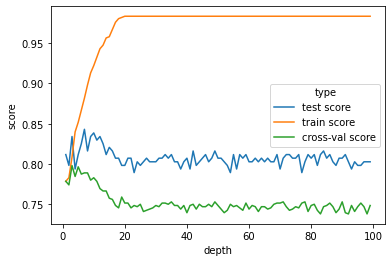

In [42]:
scores = pd.melt(scores,
                 id_vars=['depth'],
                 value_vars=['test score', 'train score', 'cross-val score'],
                 var_name='type',
                 value_name='score')
sns.lineplot(x='depth', y='score', hue='type', data=scores)

In [43]:
scores.groupby('type')['score'].max()

type
cross-val score    0.797958
test score         0.843049
train score        0.983533
Name: score, dtype: float64

In [44]:
scores[scores['score']==scores.groupby('type')['score'].max().loc['cross-val score']]

,depth,type,score
200,3.0,cross-val score,0.797958


In [45]:
best_clf = DecisionTreeClassifier(criterion='entropy', max_depth=3)
best_clf.fit(X_train, y_train)
best_clf.score(X_test, y_test)

0.8340807174887892

# Поиск наилучшей конфигурации
Мы бы хотели совместить кросс-валидацию, метрику и подбор параметров в одном месте. В sklearn реализована функция, представвляющая возможность поиска наилучших параметров модели

In [46]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_score
clf = DecisionTreeClassifier()
dict_with_parameters = {'criterion': ['gini', 'entropy'],
                        'max_depth': range(1, 30)}

grid = GridSearchCV(clf,
                    param_grid=dict_with_parameters,
                    cv=5)
grid

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': range(1, 30)})

In [95]:
grid.fit(X_train, y_train)
best_params = grid.best_params_
best_params

{'criterion': 'gini', 'max_depth': 3}

In [97]:
# уже обученная модель
best_model = grid.best_estimator_
# accuracy на тестовом наборе
best_model.score(X_test, y_test)

0.8430493273542601

In [128]:
from sklearn.metrics import precision_score, f1_score, recall_score, roc_curve, auc

predictions = best_model.predict(X_test)

P = precision_score(y_true=y_test,
                    y_pred=predictions,
                    average='micro')
R = recall_score(y_true=y_test,
                 y_pred=predictions,
                 average='micro')
F = f1_score(y_true=y_test,
             y_pred=predictions,
             average='micro')
print(f'Precision is {P}')
print(f'Recall is {R}')
print(f'F is {F}')

Precision is 0.8430493273542601
Recall is 0.8430493273542601
F is 0.8430493273542601


# ROC-кривая
Как правильно выбирать значение порога?  В этом может помочь **ROC-кривая**

На самом деле мы предсказываем **вероятность** предсказания к классам. При этом можно задавать порог, начиная с которого будет присваиваться метка. По умолчанию этот порог равен 0.5

In [103]:
probabilities_of_predictions = best_model.predict_proba(X_test)
probabilities_of_predictions

array([[0.88217523, 0.11782477],
       [0.88217523, 0.11782477],
       [0.88217523, 0.11782477],
       [0.88217523, 0.11782477],
       [0.88217523, 0.11782477],
       [0.88217523, 0.11782477],
       [0.056     , 0.944     ],
       [0.86363636, 0.13636364],
       [0.88217523, 0.11782477],
       [0.88217523, 0.11782477],
       [0.056     , 0.944     ],
       [0.88217523, 0.11782477],
       [0.88217523, 0.11782477],
       [0.056     , 0.944     ],
       [0.6097561 , 0.3902439 ],
       [0.88217523, 0.11782477],
       [0.88217523, 0.11782477],
       [0.88217523, 0.11782477],
       [0.88217523, 0.11782477],
       [0.88217523, 0.11782477],
       [0.056     , 0.944     ],
       [0.88217523, 0.11782477],
       [0.88217523, 0.11782477],
       [0.6097561 , 0.3902439 ],
       [0.88217523, 0.11782477],
       [0.43010753, 0.56989247],
       [0.6097561 , 0.3902439 ],
       [0.88217523, 0.11782477],
       [0.43010753, 0.56989247],
       [0.88217523, 0.11782477],
       [0.

<AxesSubplot:>

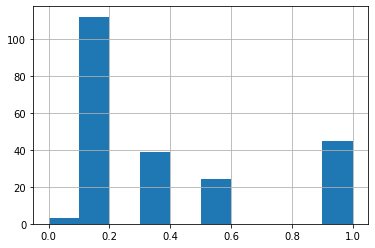

In [106]:
# распределение вероятности для класса 1 (выжившие)
pd.Series(probabilities_of_predictions[:, 1]).hist()

Если мы хотим максимизировать precision (то есть минизировать число ложных предсказаний выживших людей), то есть быть "сверхуверены" в том, что человек выжил, нужно сделать порог более "строгим", например, 0.6

In [120]:
y_pred = np.where(probabilities_of_predictions[:, 1] > 0.6, 1, 0)
P = precision_score(y_true=y_test,
                    y_pred=y_pred,
                    )
R = recall_score(y_true=y_test,
                 y_pred=y_pred,
                 )
F = f1_score(y_true=y_test,
             y_pred=y_pred,
             )
print(f'Precision is {P}')
print(f'Recall is {R}')
print(f'F is {F}')

Precision is 0.9777777777777777
Recall is 0.5116279069767442
F is 0.6717557251908397


In [122]:
# их немного, так как каждая запись в таблице имеет какой-то путь в дереве
np.unique(probabilities_of_predictions)

array([0.        , 0.056     , 0.11782477, 0.13636364, 0.3902439 ,
       0.43010753, 0.56989247, 0.6097561 , 0.86363636, 0.88217523,
       0.944     , 1.        ])

Теперь визуализируем ROC-кривую (код из документации https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html)

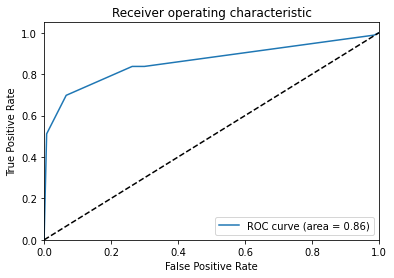

In [134]:
fpr, tpr, thresholds = roc_curve(y_test, probabilities_of_predictions[:,1])
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % (roc_auc))
plt.plot([0, 1], [0, 1] , 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")

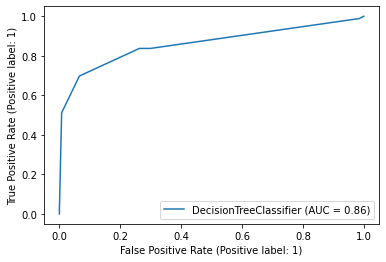

In [135]:
# другой способ
from sklearn.metrics import plot_roc_curve
plot_roc_curve(best_model, X_test, y_test)

**True Positive Rate** - какой % выживших пассажиров мы классифицировали правильно (recall)
**False Positive Rate** - как часто мы делали ошибки признания выжившим человека, который не выжил (какой % от невыживших мы классифицировали неправильно)

# Ещё некоторые параметры у дерева
- Глубина дерева (`max_depth`) - это самый "серьезный" параметр у дерева (default = максимально)
- `min_samples_split` - минимальное число попавших в лист наблюдений, чтобы разделить его (default=2)
- `min_samples_leaf` - минимальное число число наблюдений в листе

In [47]:
from sklearn.tree import plot_tree

[Text(167.4, 190.26, 'X[5] <= 0.5\nentropy = 0.96\nsamples = 668\nvalue = [412, 256]'),
 Text(83.7, 135.9, 'X[0] <= 2.5\nentropy = 0.851\nsamples = 242\nvalue = [67, 175]'),
 Text(41.85, 81.53999999999999, 'X[4] <= 29.356\nentropy = 0.339\nsamples = 127\nvalue = [8, 119]'),
 Text(20.925, 27.180000000000007, 'entropy = 0.523\nsamples = 51\nvalue = [6, 45]'),
 Text(62.775000000000006, 27.180000000000007, 'entropy = 0.176\nsamples = 76\nvalue = [2, 74]'),
 Text(125.55000000000001, 81.53999999999999, 'X[4] <= 24.808\nentropy = 1.0\nsamples = 115\nvalue = [59, 56]'),
 Text(104.625, 27.180000000000007, 'entropy = 0.989\nsamples = 96\nvalue = [42, 54]'),
 Text(146.475, 27.180000000000007, 'entropy = 0.485\nsamples = 19\nvalue = [17, 2]'),
 Text(251.10000000000002, 135.9, 'X[0] <= 1.5\nentropy = 0.702\nsamples = 426\nvalue = [345, 81]'),
 Text(209.25, 81.53999999999999, 'X[1] <= 53.0\nentropy = 0.97\nsamples = 83\nvalue = [50, 33]'),
 Text(188.32500000000002, 27.180000000000007, 'entropy = 0.9

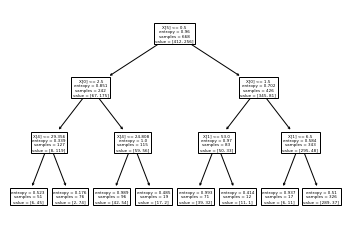

In [24]:
clf = DecisionTreeClassifier(criterion='entropy', max_depth=3,
                             min_samples_leaf=10, min_samples_split=9)
clf.fit(X_train, y_train)

display(plot_tree(clf))

In [49]:
params = {'min_samples_leaf': range(5, 16, 3), 
          'max_depth': range(2, 10),
          'min_samples_split': range(5, 16, 3)}
grid = GridSearchCV(DecisionTreeClassifier(criterion='entropy'),
                    param_grid=params,
                    cv=3)
grid.fit(X_train, y_train)
grid.best_estimator_

DecisionTreeClassifier(criterion='entropy', max_depth=6, min_samples_leaf=5,
                       min_samples_split=8)